# Présentation du projet

### Alexandre Camille Becelhi


## Rappel des objectifs

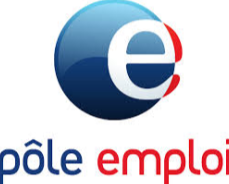

* Utilisation de techniques de Webscraping pour récupérer des informations dans des offres issues de Pôle Emploi
* Implémentation des données dans une base fonctionnelle
* Automatisation par le biais du CRON


## Définition des critères de recherche : 

Offres correspondant au mot clé **Data** et à trois Régions différentes :

#### *La région Centre :*

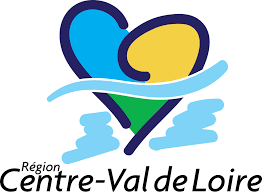

#### *La région Pays de la Loire :*

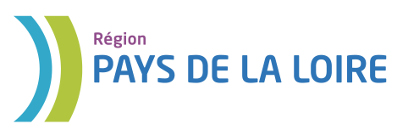


#### *La région Auvergne-Rhône-Alpes :*

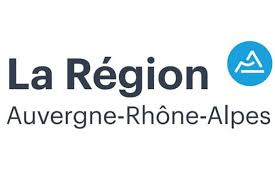

## Organisation globale

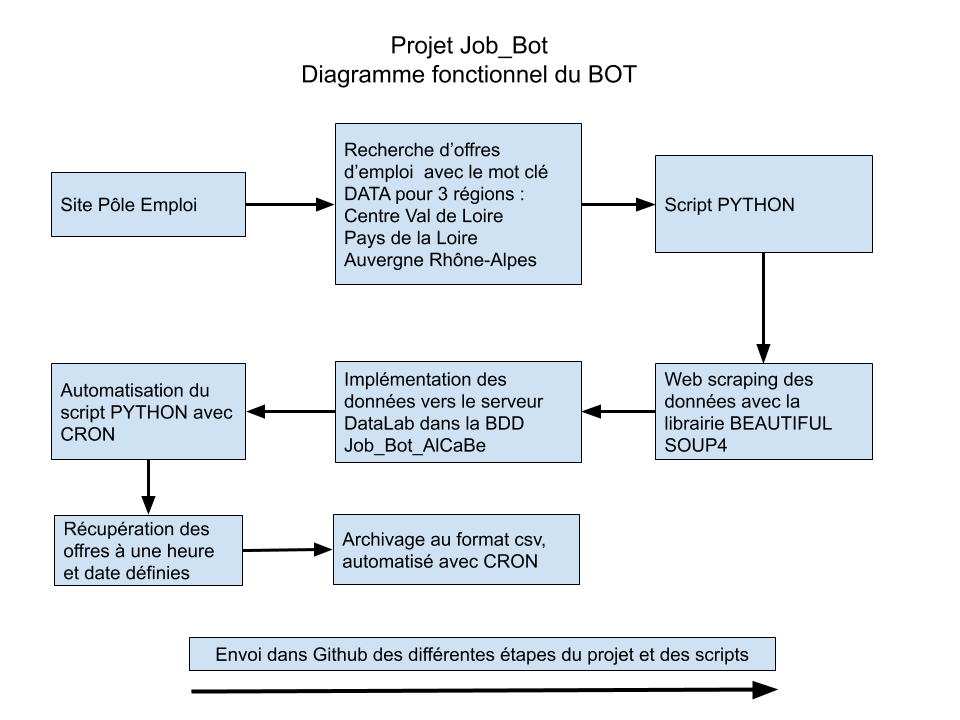

## Planification Github  


https://github.com/datalab-greta/Camille_Alexandre_Becelhi_Projet_3/projects/1

## Présentation du code
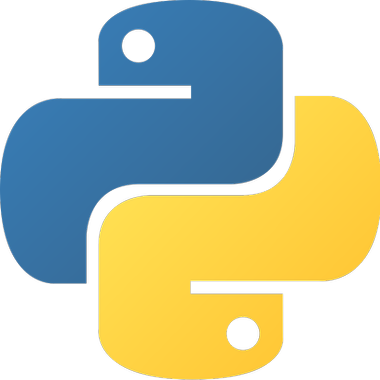

In [1]:
#Importation des librairies
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
from sqlalchemy import create_engine, text

#Définition de l'accès à la BDD
user='team'
password='DataLab@2019'
machine='127.0.0.1'
base_donnees='Job_Bot_AlCaBe'
#base_donnees='BDD_Alexandre_job_bot' #Ceci est ma base de test
mySQLengine = create_engine("mysql://%s:%s@%s/%s?charset=utf8" % (user, password, machine, base_donnees))

#Définition du lieu, des mots clés et de l'url
lieu="24R"
motcle="data"

html= urlopen("https://candidat.pole-emploi.fr/offres/recherche?lieux="+lieu+"&motsCles="+motcle+"&offresPartenaires=true&range=0-150&tri=0").read()#Définition de l'url et conversion BeautifulSoup

soup = BeautifulSoup(html, features="lxml")


In [2]:
#Définition du nombre d'offres
titre = soup.find('h1', class_ ='title')
nb_offre = titre.next_element.replace('\n', '')
N=nb_offre.replace(' offres', '')
N=int(N)

#Intégration de la boucle, avec liste des URL différents (si applicables) dans une dataframe
Urlsliste=[]

i=0
while(i<N):
    imax = i+99 if (i+99<N) else N
    if imax>N:
        imax=N
    rg="%d-%d" % (i, imax)
    print(rg)
    URL="https://candidat.pole-emploi.fr/offres/recherche?lieux="+lieu+"&motsCles="+motcle+"&offresPartenaires=true&range="+rg+"&tri=0"
    print(URL)
    Urlsliste.append(URL)
    print(Urlsliste)
    i+=100

0-9
https://candidat.pole-emploi.fr/offres/recherche?lieux=24R&motsCles=data&offresPartenaires=true&range=0-9&tri=0
['https://candidat.pole-emploi.fr/offres/recherche?lieux=24R&motsCles=data&offresPartenaires=true&range=0-9&tri=0']


In [3]:
#Définition du contenu de la dataframe globale
Titles=[]
Type_Contrat=[]
Localisation=[]
Reference=[]
Lien=[]
Urlsliste=pd.DataFrame(Urlsliste)
Urlsliste.columns=["Urls"]
##Boucles pour récupération du contenu de la page d'accueil Pôle Emploi

for myurls in Urlsliste["Urls"]:
    soup = BeautifulSoup(urlopen(myurls).read(), features="lxml")
    for tag in soup.find_all('h2', class_ ='t4 media-heading'):
        Titles.append(tag.text)
    for tag in soup.find_all('p', class_ ='contrat visible-xs'):
        Type_Contrat.append(tag.text)
    for tag in soup.find_all('p', class_ ='subtext'):
        Localisation.append(tag.text)
    for result in soup.find_all(class_ ='result'):
        Reference.append(result['data-id-offre'])
        Lien.append(result.find('a', class_ ='btn-reset')['href'])

In [4]:

###Création d'une dataframe avec lien et adresse complète
Liendf=pd.DataFrame(Lien)
Liendf.columns=['Liens']
Liendf['Liens'].replace('/offres/', 'https://candidat.pole-emploi.fr/offres/', inplace=True, regex=True)

##Boucles pour récupération du contenu des offres Pole emploi
Date=[]
Exp=[]
#Competence=[]
for links in Liendf['Liens']:
    soup2 = BeautifulSoup(urlopen(links).read(), features="lxml")    
    for a in soup2.find_all(itemprop="datePosted"):
        Date.append(a.text)
    for exp in soup2.find_all(itemprop="experienceRequirements"):
        Exp.append(exp.text)

#Création Data frame pour csv
data={'Nom des offres': Titles,
      'Date de parution': Date,
      'Type de contrat': Type_Contrat,
      'Expérience': Exp,
      'Localisation': Localisation,
      'Références': Reference,
      'Liens':Lien}
df = pd.DataFrame(data)

##Regex
df['Localisation'].replace('-p', '- ', inplace=True, regex=True)
df['Date de parution'].replace('pO', ' O', inplace=True, regex=True)
#df['Date de parution'].replace('Offre avec peu de candidats', '- (Offre avec peu de candidats)', inplace=True, regex=True)
df['Liens'].replace('/offres/', 'https://candidat.pole-emploi.fr/offres/', inplace=True, regex=True)

titre = soup.find('h1', class_ ='title')
nb_offre = titre.next_element.replace('\n', '')
print(df)
print("Ma recherche comporte", nb_offre, "en région Centre !")

                                      Nom des offres  \
0  \nDATA ENGINEER (H/F) - CDI - NIORT - CERFRANCE\n   
1  \nTECHNICIEN MASTER DATA / GESTION DE PRODUCTI...   
2  \nResponsable Data - Qualité des Données SI F/...   
3  \nCDI - Chargé de Méthodes, Outils et Master D...   
4  \nChargé d'études statistiques - Data analyst ...   
5                       \nIngénieur data scientist\n   
6                \nExpert Data F/H - Qualité (H/F)\n   
7  \nDélégué / Déléguée à la protection des donné...   
8          \nResponsable unité data management H/F\n   

                     Date de parution        Type de contrat  \
0  \nActualisé le 12 septembre 2019\n  CDI\n - Non renseigné   
1     \nPublié le 11 septembre 2019\n  CDI\n - Non renseigné   
2     \nPublié le 10 septembre 2019\n  CDI\n - Non renseigné   
3     \nPublié le 04 septembre 2019\n  CDI\n - Non renseigné   
4     \nPublié le 03 septembre 2019\n  CDI\n - Non renseigné   
5  \nActualisé le 09 septembre 2019\n    CDI\n - Temps 

In [1]:
##CSV

df.to_sql('Archives_région_Centre', mySQLengine, if_exists='append', index=False,chunksize=1)

#Database
statement = text("""
INSERT INTO `Offres_région_Centre`
SELECT DISTINCT * FROM `Archives_région_Centre` WHERE `Archives_région_Centre`.`Références`NOT IN (SELECT `Références` FROM `Offres_région_Centre`)
ON DUPLICATE KEY UPDATE Offres_région_Centre.Expérience = Archives_région_Centre.Expérience
;
""")
#mySQLengine.execute(statement)

select = mySQLengine.execute('SELECT * FROM Offres_région_Centre')
ResultSet = select.fetchall()
ResultSet = pd.DataFrame(ResultSet)
ResultSet.columns = df.columns# ['Nom des offres', 'Date de parution', 'Type de contrat', ]
print("Voilà la base :", ResultSet)
ResultSet.to_csv('~/Archive/Base_content.csv',index=False, header=False)

NameError: name 'df' is not defined

In [ ]:
#python /home/moi/Documents/Projet_3_webscraping/Python/Scraping_v3.3.py

## Mise en place du CRON en utilisant Crontab

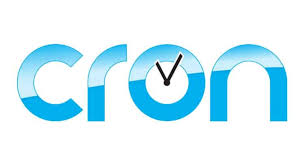

https://crontab.guru/#*_*_4_*_*/04_wed

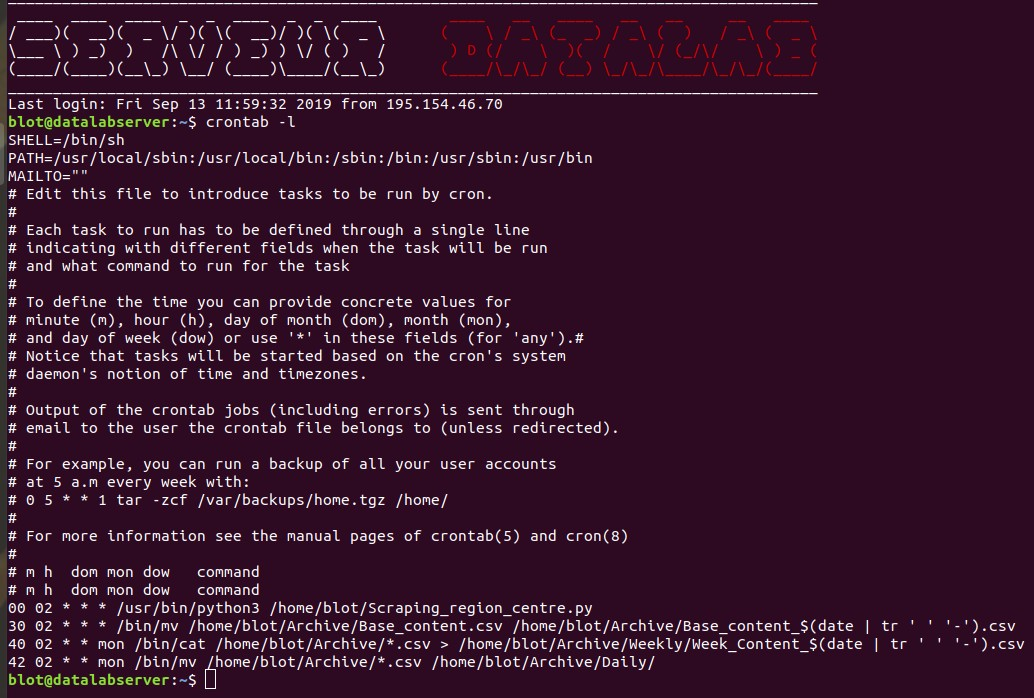

* Exécution du script
    * Génère un fichier csv correspondant au contenu de la table après insertion
* Tri des fichiers dans des sous dossiers
    * Ajout de la table
    * Tri automatique chaque lundi

# Conclusion